# Predict House price
## *Comparing 8 regression algorithms*

![house](https://i.imgur.com/HGsQXQS.png)

This dataset contains house sale prices for King County, which includes Seattle. It includes homes sold between May 2014 and May 2015.

# Table of contents

[<h3>1. Data Analysis & Data Processing</h3>](#1)

[<h3>2. Model comparison</h3>](#2)

[<h3>3. Prediction metrics of the best model using the test set</h3>](#3)

[<h3>4. Visualization of the result</h3>](#4)


# Load the libraries

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso, LassoCV, ElasticNet, ElasticNetCV, Ridge, RidgeCV, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from time import perf_counter
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import *
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
import lightgbm as lgb
from mlxtend.regressor import StackingCVRegressor

from IPython.display import Markdown, display

def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))

import warnings
warnings.filterwarnings(action='ignore')

# 1. Data Analysis & Data Processing<a class="anchor" id="1"></a><a class="anchor" id="1"></a>

In [2]:
import os
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/My Drive"

os.chdir(path)
os.listdir(path)

Mounted at /content/drive


['kc_house_data.csv',
 'Colab Notebooks',
 'price prediction.py',
 'house_data.csv',
 'outfile.png',
 'Housing Price Prediction.ipynb']

In [3]:
import pandas as pd
df = pd.read_csv("/content/drive/My Drive/kc_house_data.csv")

In [4]:
# df = pd.read_csv('../input/housesalesprediction/kc_house_data.csv', index_col = 0)
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [6]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


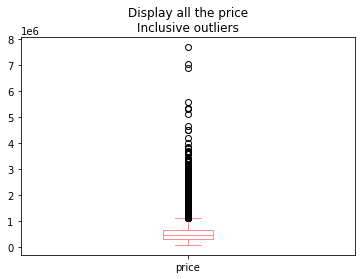

In [7]:
df['price'].plot.box(by='price', color = '#ff8c8e')
plt.title('Display all the price\nInclusive outliers')
plt.show()

As we can see there are strong outliers. We'll filter them out and keep only the prices lower than 1.000.000.

In [8]:
# df = df[df['price'] < 1000000]

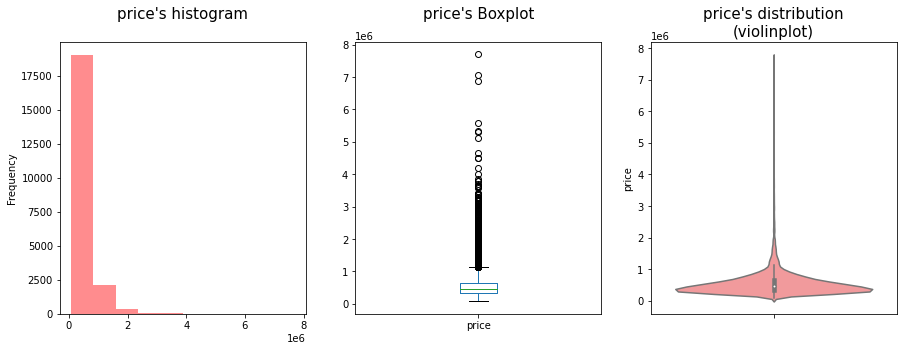

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

df['price'].plot.hist(by='price',ax = axes[0], color = '#ff8c8e')
axes[0].set_title('price\'s histogram\n', fontsize = 15)

df['price'].plot.box(ax = axes[1])
axes[1].set_title('price\'s Boxplot\n', fontsize = 15)

sns.violinplot(ax = axes[2], y = 'price', data = df, color = '#ff8c8e')
axes[2].set_title('price\'s distribution\n(violinplot)', fontsize = 15)

plt.show()

In [10]:
printmd(f'### Number of rows in the dataset: {df.shape[0]}')

### Number of rows in the dataset: 21613

### Add a column to the DataFrame: age
The data are from the year 2014 and 2015. We'll take 2015 to simplify the calculation.The age is whether the number of years since the house was built or if it has been
renovated, the number of years since the renovation.

In [11]:
# Add the column age
df['age'] = [2015 - x[0] if x[1]==0 else 2015 - x[1] for x in df[['yr_built','yr_renovated']].values]

# Display the result
df[['yr_built','yr_renovated','age']].head()

,yr_built,yr_renovated,age
0,1955,0,60
1,1951,1991,24
2,1933,0,82
3,1965,0,50
4,1987,0,28


In [12]:
# Select some columns, which will be used in the regression model
cols =['price','bedrooms','bathrooms','sqft_living','sqft_lot','floors',
     'waterfront','view','condition','grade','sqft_above','sqft_basement',
     'yr_built','yr_renovated','lat','long','sqft_living15',
     'sqft_lot15','age']
df = df[cols]
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,age
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,47.5112,-122.257,1340,5650,60
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,47.7210,-122.319,1690,7639,24
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,47.7379,-122.233,2720,8062,82
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,47.5208,-122.393,1360,5000,50
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,47.6168,-122.045,1800,7503,28


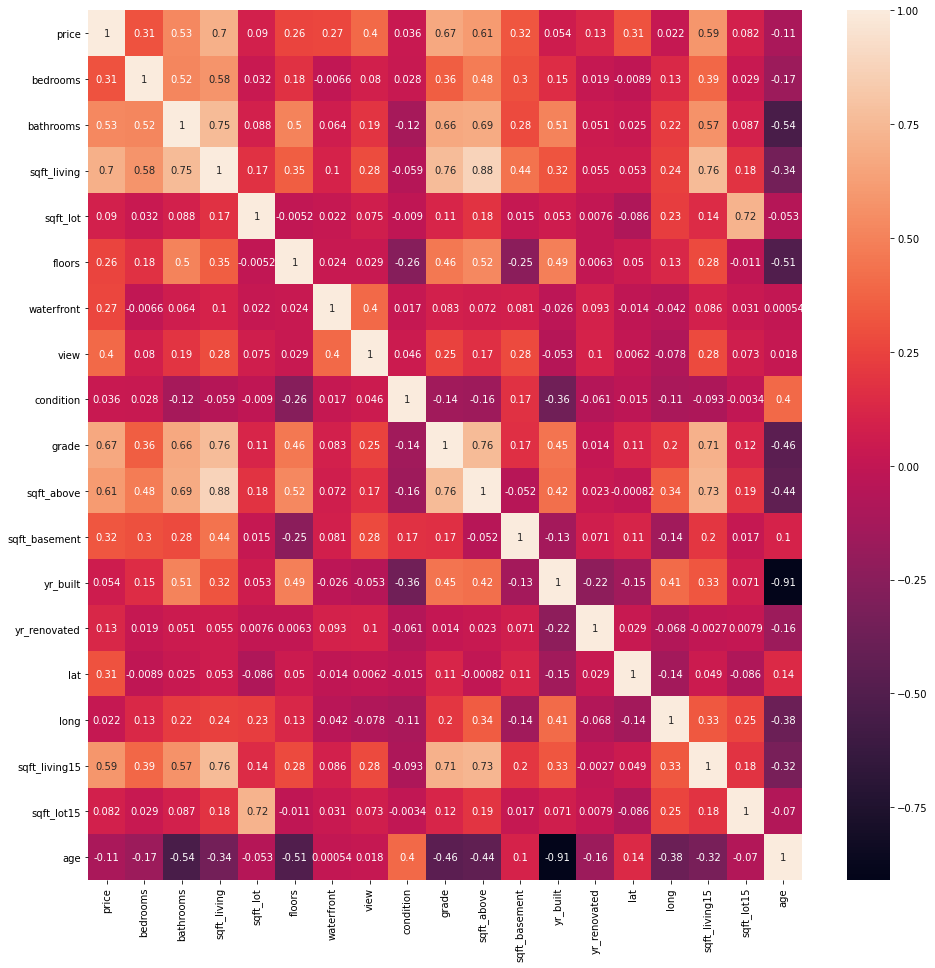

In [13]:
corrs = df.corr()
plt.figure(figsize=(16, 16))
sns.heatmap(corrs,annot = True)

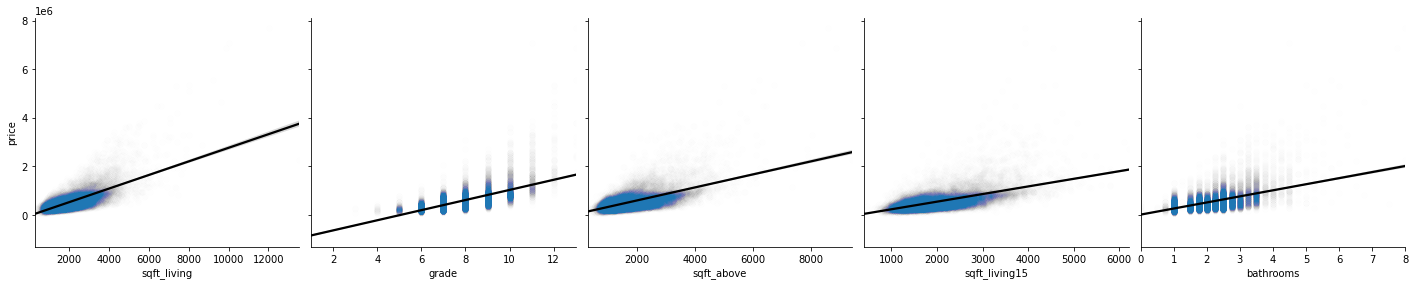

In [14]:
# Visualization
sns.pairplot(df[cols], 
             kind='reg', 
             plot_kws={'line_kws':{'color':'black'}, 'scatter_kws': {'alpha': 0.005}},
             y_vars=['price'],
             x_vars=['sqft_living','grade','sqft_above','sqft_living15','bathrooms'],
             height = 4
            )
plt.show()

In [15]:
df.corr()['price'].sort_values(ascending = False)  #重点关注sqft_livin

price            1.000000
sqft_living      0.702035
grade            0.667434
sqft_above       0.605567
sqft_living15    0.585379
bathrooms        0.525138
view             0.397293
sqft_basement    0.323816
bedrooms         0.308350
lat              0.307003
waterfront       0.266369
floors           0.256794
yr_renovated     0.126434
sqft_lot         0.089661
sqft_lot15       0.082447
yr_built         0.054012
condition        0.036362
long             0.021626
age             -0.105755
Name: price, dtype: float64

Text(0.5, 0, 'long')

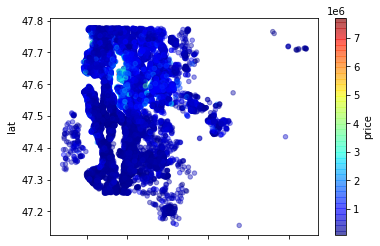

In [16]:
# 异常值处理之前

df.plot(kind='scatter', x='long' , y='lat', alpha=0.4,
        c="price", cmap=plt.get_cmap("jet"), colorbar=True)
plt.xlabel('long')

In [17]:
def outliers_proc(data, col_name, scale=1):
    """
    用于清洗异常值，默认用 box_plot（scale=3）进行清洗
    :param data: 接收 pandas 数据格式
    :param col_name: pandas 列名
    :param scale: 尺度
    :return:
    """

    def box_plot_outliers(data_ser, box_scale):
        """
        利用箱线图去除异常值
        :param data_ser: 接收 pandas.Series 数据格式
        :param box_scale: 箱线图尺度，
        :return:
        """
        iqr = box_scale * (data_ser.quantile(0.75) - data_ser.quantile(0.25))
        val_low = data_ser.quantile(0.25) - 1.5 * iqr
        val_up = data_ser.quantile(0.75) + 1.5 * iqr
        rule_low = (data_ser < val_low)
        rule_up = (data_ser > val_up)
        return (rule_low, rule_up), (val_low, val_up)

    data_n = data.copy()
    data_series = data_n[col_name]
    rule, value = box_plot_outliers(data_series, box_scale=scale)
    index = np.arange(data_series.shape[0])[rule[0] | rule[1]]
    print("Delete number is: {}".format(len(index)))
    data_n = data_n.drop(index)
    data_n.reset_index(drop=True, inplace=True)
    print("Now column number is: {}".format(data_n.shape[0]))
    index_low = np.arange(data_series.shape[0])[rule[0]]
    outliers = data_series.iloc[index_low]
    print("Description of data less than the lower bound is:")
    print(pd.Series(outliers).describe())
    index_up = np.arange(data_series.shape[0])[rule[1]]
    outliers = data_series.iloc[index_up]
    print("Description of data larger than the upper bound is:")
    print(pd.Series(outliers).describe())
    
    fig, ax = plt.subplots(1, 2, figsize=(5, 3))
    sns.boxplot(y=data[col_name], data=data, palette="Set1", ax=ax[0]).set(xlabel="before")
    sns.boxplot(y=data_n[col_name], data=data_n, palette="Set1", ax=ax[1]).set(xlabel="after")
    plt.tight_layout()
    return data_n

Delete number is: 1146
Now column number is: 20467
Description of data less than the lower bound is:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: price, dtype: float64
Description of data larger than the upper bound is:
count    1.146000e+03
mean     1.667087e+06
std      6.523358e+05
min      1.130000e+06
25%      1.260125e+06
50%      1.450000e+06
75%      1.813750e+06
max      7.700000e+06
Name: price, dtype: float64
Delete number is: 487
Now column number is: 19980
Description of data less than the lower bound is:
count    210.000000
mean       0.942857
std        0.232670
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: bedrooms, dtype: float64
Description of data larger than the upper bound is:
count    277.000000
mean       6.361011
std        1.756869
min        6.000000
25%        6.000000
50%        6.000000
75%        6.000000
max       33.000000
Name: be

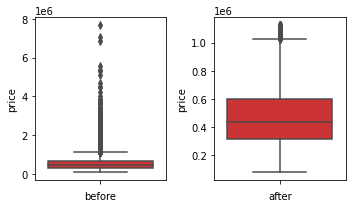

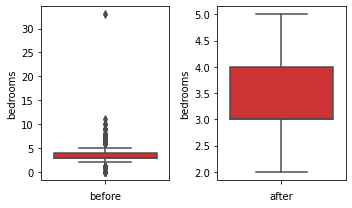

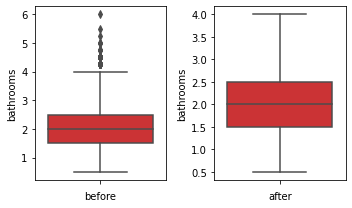

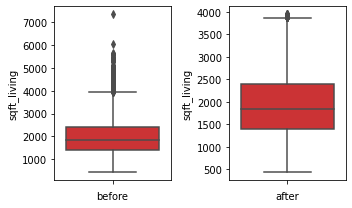

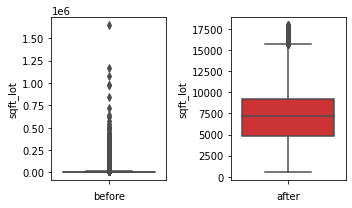

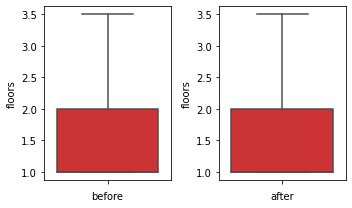

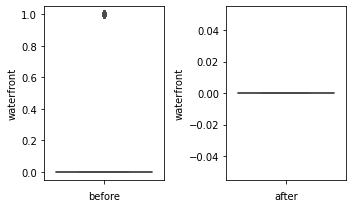

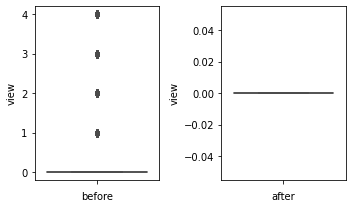

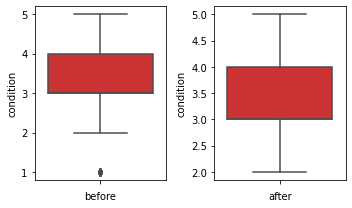

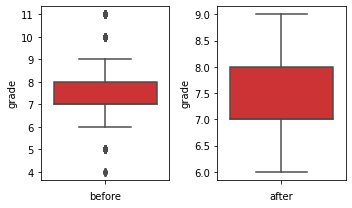

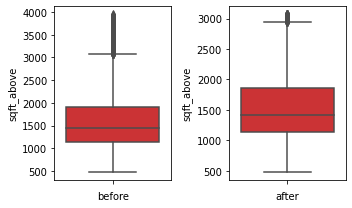

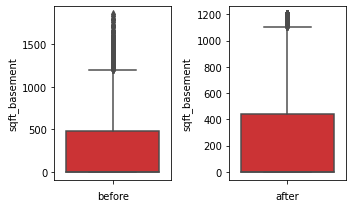

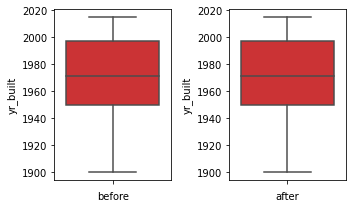

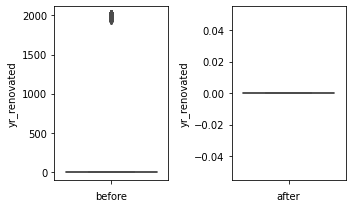

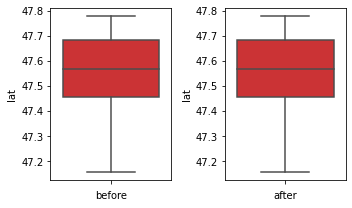

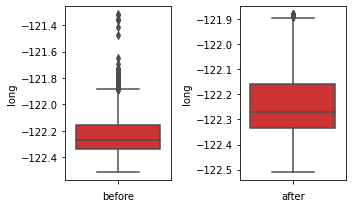

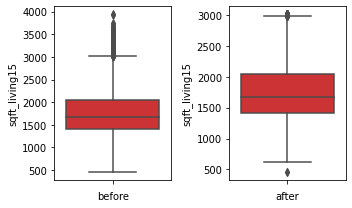

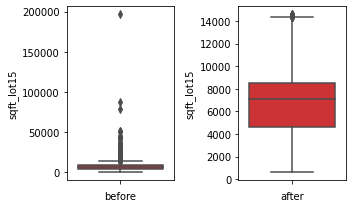

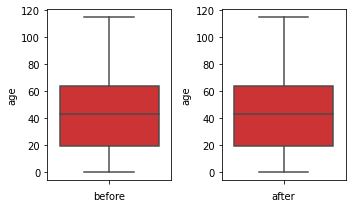

In [18]:
for i in df.columns.values.tolist():
    if str(df[i]) != 'int64':
        df[i] = df[i].apply(pd.to_numeric)
        df = outliers_proc(df,i)
    else:
        df = outliers_proc(df,i)

In [19]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13868 entries, 0 to 13867
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          13868 non-null  float64
 1   bedrooms       13868 non-null  int64  
 2   bathrooms      13868 non-null  float64
 3   sqft_living    13868 non-null  int64  
 4   sqft_lot       13868 non-null  int64  
 5   floors         13868 non-null  float64
 6   waterfront     13868 non-null  int64  
 7   view           13868 non-null  int64  
 8   condition      13868 non-null  int64  
 9   grade          13868 non-null  int64  
 10  sqft_above     13868 non-null  int64  
 11  sqft_basement  13868 non-null  int64  
 12  yr_built       13868 non-null  int64  
 13  yr_renovated   13868 non-null  int64  
 14  lat            13868 non-null  float64
 15  long           13868 non-null  float64
 16  sqft_living15  13868 non-null  int64  
 17  sqft_lot15     13868 non-null  int64  
 18  age   

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,age
count,1.386800e+04,13868.000000,13868.000000,13868.000000,13868.000000,13868.000000,13868.0,13868.0,13868.000000,13868.000000,13868.000000,13868.000000,13868.000000,13868.0,13868.000000,13868.000000,13868.000000,13868.000000,13868.000000
mean,4.284984e+05,3.222310,1.940186,1745.241131,6802.615734,1.458357,0.0,0.0,3.429911,7.330112,1523.848067,221.393063,1970.466325,0.0,47.559275,-122.239109,1741.426377,6700.944909,44.533675
std,1.746334e+05,0.760002,0.644860,552.526973,3187.153082,0.550585,0.0,0.0,0.653765,0.777317,534.429641,335.317277,29.310014,0.0,0.143195,0.116460,452.393958,2829.674267,29.310014
min,8.200000e+04,2.000000,0.500000,560.000000,520.000000,1.000000,0.0,0.0,2.000000,6.000000,480.000000,0.000000,1900.000000,0.0,47.189500,-122.472000,620.000000,651.000000,0.000000
25%,2.950000e+05,3.000000,1.500000,1320.000000,4539.000000,1.000000,0.0,0.0,3.000000,7.000000,1120.000000,0.000000,1951.000000,0.0,47.455575,-122.337000,1410.000000,4650.000000,19.000000
50%,3.990000e+05,3.000000,2.000000,1690.000000,6978.500000,1.000000,0.0,0.0,3.000000,7.000000,1400.000000,0.000000,1972.000000,0.0,47.571600,-122.275000,1670.000000,7103.000000,43.000000
75%,5.345350e+05,4.000000,2.500000,2130.000000,8760.000000,2.000000,0.0,0.0,4.000000,8.000000,1830.000000,440.000000,1996.000000,0.0,47.684200,-122.163000,2030.000000,8545.000000,64.000000
max,1.125000e+06,5.000000,4.000000,3930.000000,17859.000000,3.500000,0.0,0.0,5.000000,9.000000,3070.000000,1200.000000,2015.000000,0.0,47.777600,-121.882000,3010.000000,14602.000000,115.000000


Text(0.5, 0, 'long')

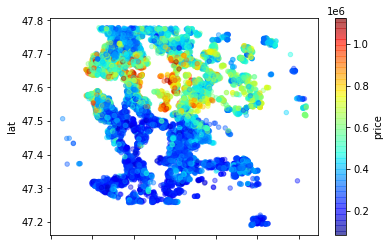

In [20]:
# 异常值处理之后
df.plot(kind='scatter', x='long', y='lat', alpha=0.4,
        c="price", cmap=plt.get_cmap("jet"), colorbar=True).set_xlabel('long')


In [21]:
def preprocessing(df):
    df = df.copy()
       
    # Shuffle the data
    # df = df.sample(frac=1.0, random_state=0).reset_index(drop=True)
    
    X = df.drop('price', axis=1)
    y = df['price']
    
    X = pd.DataFrame(X, index=X.index, columns=X.columns)
    
    return X, y

# Preprocessing
X,y = preprocessing(df)

# Split into a training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the datasets
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Display the result
print(X_train)
print(X_train.shape)

# PCA
# pca = PCA(n_components=0.98)
# pca.fit(X_train)
# X_train_dunction = pca.transform(X_train)
# X_test_dunction = pca.transform(X_test)

# print(X_train_dunction)
# print(X_train_dunction.shape)

# LDA
# lda = LinearDiscriminantAnalysis()
# lda.fit(X_train,y_train)
# X_train_lda = lda.transform(X_train)
# X_test_lda = lda.transform(X_test)

# print(X_train_lda)
# print(X_train_lda.shape)


[[ 1.02221743  0.87176796  1.88511403 ... -0.18144841  0.53201121
  -1.17360606]
 [-0.28564558 -1.46168718 -1.34448705 ... -1.63388469 -0.97902386
   1.44893962]
 [ 1.02221743  0.87176796  1.07320314 ...  1.00690855  2.02147017
  -0.96925185]
 ...
 [-0.28564558 -1.46168718 -0.96559531 ... -1.36980537  0.26602376
   0.73369989]
 [-0.28564558 -0.6838688  -0.26193921 ... -0.07141536  0.46409952
   0.2568734 ]
 [-0.28564558  0.48285877  0.11695254 ... -0.00539553  1.0059782
  -0.45836633]]
(11094, 18)


Skewness of target: 0.8776579994491077
kurtosis of target: 0.6244195395742058


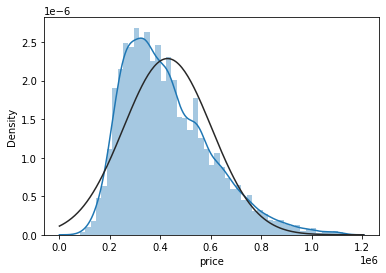

In [22]:
#因为由前文可知，目标值明显右偏，故取对数，使其近似正态分布

sns.distplot(y_train, fit=norm)
print('Skewness of target:', y_train.skew())
print('kurtosis of target:', y_train.kurtosis())

Skewness of target: -0.09802037390966695
kurtosis of target: -0.29136147505401544


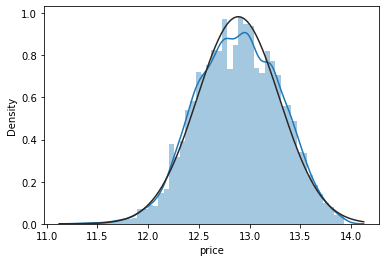

In [23]:
y_train = np.log1p(y_train)
print('Skewness of target:', y_train.skew())
print('kurtosis of target:', y_train.kurtosis())
sns.distplot(y_train, fit=norm)

# 2. Model comparison<a class="anchor" id="2"></a>

In [24]:
#Lasso
lasso_alpha = [0.00005, 0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0]
lasso = make_pipeline(RobustScaler(), LassoCV(alphas=lasso_alpha, random_state=2))

#ElasticNet
#enet_beta = [0.1, 0.2, 0.5, 0.6, 0.8, 0.9]
#enet_alpha = [0.00005, 0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01]
#ENet = make_pipeline(RobustScaler(), ElasticNetCV(l1_ratio=enet_beta, alphas=enet_alpha, random_state=12))

#Ridge
#rid_alpha = [0.00005, 0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0]
#rid = make_pipeline(RobustScaler(), RidgeCV(alphas=rid_alpha))

#Gradient Boosting
gbr_params = {'loss': 'huber',
      'criterion': 'mse', 
      'learning_rate': 0.1,
      'n_estimators': 600, 
      'max_depth': 4,
      'subsample': 0.6,
      'min_samples_split': 20,
      'min_samples_leaf': 5,
      'max_features': 0.6,
      'random_state': 32,
      'alpha': 0.5}
gbr = GradientBoostingRegressor(**gbr_params)

#LightGBM
lgbr_params = {'learning_rate': 0.01,
      'n_estimators': 1850, 
      'max_depth': 8,
      'num_leaves': 50,
      'subsample': 0.6,
      'colsample_bytree': 0.6,
      'min_child_weight': 0.001,
      'min_child_samples': 21,
      'random_state': 42,
      'reg_alpha': 0,
      'reg_lambda': 0.05}
lgbr = lgb.LGBMRegressor(**lgbr_params)

#rfr = RandomForestRegressor(n_estimators=600,max_depth=16,min_samples_split=4,random_state=42)

lin = LinearRegression()

stack_model = StackingCVRegressor(regressors=(lasso, gbr, lgbr), meta_regressor=lasso, use_features_in_secondary=True)

In [25]:
models = {
    "LinearRegression":{"model":lin },
    "Lasso":{"model":lasso },
    # "Ridge":{"model":rid },
    # "DecisionTreeRegressor":{"model":DecisionTreeRegressor() },
    # "ElasticNet":{"model":ENet },
    # "RandomForestRegressor":{"model":rfr },
    # "MLPRegressor":{"model":MLPRegressor() },
    "LightGBM":{"model":lgbr },
    "GradientBoostingRegressor":{"model":gbr },
    "Stacking":{"model":stack_model }
    # "AdaBoostRegressor":{"model":AdaBoostRegressor() }
}

In [26]:
# Use the K-fold cross validation for each model
# to get the mean validation accuracy and the mean training time
k = 5
for name, m in models.items():
    # Cross validation of the model
    model = m['model']
    result = cross_validate(model, X_train,y_train, cv = k, scoring='neg_mean_squared_error')
    
    # Mean accuracy and mean training time
    result['test_score'] = result['test_score']
    mean_RMSE = [(-x)**0.5 for x in result['test_score']] # Root Mean Square Error
    mean_RMSE = sum(mean_RMSE)/len(mean_RMSE)
    # mean_RMSE = int(mean_RMSE)
    mean_fit_time = round( sum(result['fit_time']) / len(result['fit_time']), 4)
    
    # Add the result to the dictionary witht he models
    m['mean_RMSE'] = mean_RMSE
    m['Training time (sec)'] = mean_fit_time
    
    # Display the result
    print(f"{name:27} mean MSRE for {k}-fold CV: {mean_RMSE} - mean training time {mean_fit_time} sec")

LinearRegression            mean MSRE for 5-fold CV: 0.22974087403652205 - mean training time 0.0162 sec
Lasso                       mean MSRE for 5-fold CV: 0.2297399946019682 - mean training time 0.1872 sec
LightGBM                    mean MSRE for 5-fold CV: 0.14855924898721154 - mean training time 4.3689 sec
GradientBoostingRegressor   mean MSRE for 5-fold CV: 0.15239295611049855 - mean training time 9.2324 sec
Stacking                    mean MSRE for 5-fold CV: nan - mean training time 0.0049 sec


In [27]:
# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    lst = [name, v['mean_RMSE'],v['Training time (sec)']]
    models_result.append(lst)

df_results = pd.DataFrame(models_result, 
                          columns = ['model','RMSE','Training time (sec)'])
df_results.sort_values(by='RMSE', ascending=True, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

,model,RMSE,Training time (sec)
0,LightGBM,0.148559,4.3689
1,GradientBoostingRegressor,0.152393,9.2324
2,Lasso,0.229740,0.1872
3,LinearRegression,0.229741,0.0162
4,Stacking,NaN,0.0049


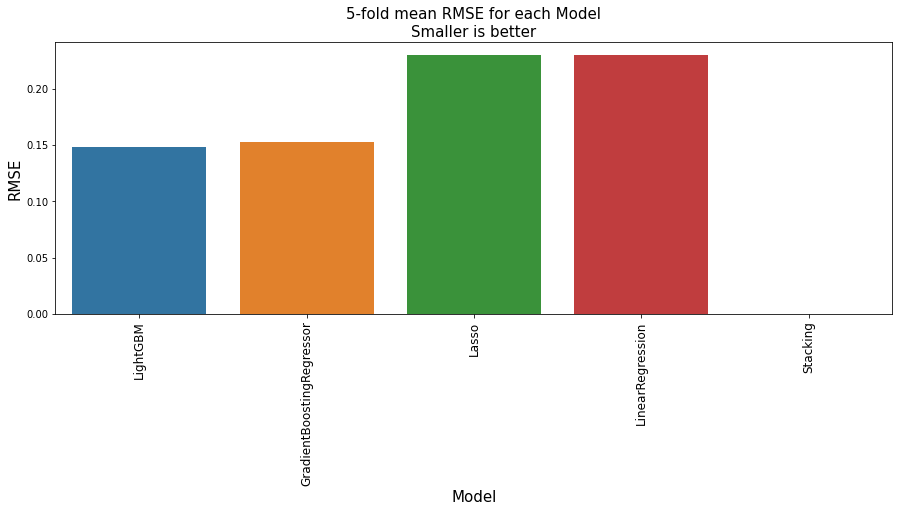

In [28]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'RMSE', data = df_results)
plt.title(f'{k}-fold mean RMSE for each Model\nSmaller is better', fontsize = 15)
# plt.ylim(0.8,1.005)
plt.xlabel('Model', fontsize=15)
plt.ylabel('RMSE',fontsize=15)
plt.xticks(rotation=90, fontsize=12)
plt.show()

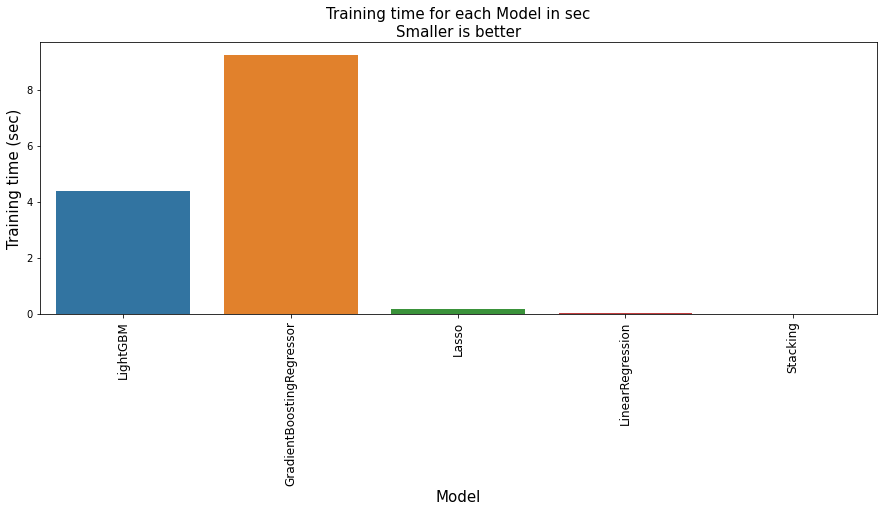

In [29]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'Training time (sec)', data = df_results)
plt.title('Training time for each Model in sec\nSmaller is better', fontsize = 15)
plt.xticks(rotation=90, fontsize=12)
plt.xlabel('Model', fontsize=15)
plt.ylabel('Training time (sec)',fontsize=15)
plt.show()

# 3. Prediction metrics of the best model using the test set<a class="anchor" id="3"></a>

In [30]:
# Get the model with the highest mean validation accuracy
best_model = df_results.iloc[0]

# Fit the model
model = models[best_model[0]]['model']
model.fit(X_train,y_train)

# Predict the labels with the data set
pred = model.predict(X_test)

RMSE = mean_squared_error(np.log1p(y_test),pred)**0.5
RMSE = RMSE

# Display the results
printmd(f'### Best Model: {best_model[0]} with a RMSE of {RMSE} on the test set')
printmd(f'### Trained in: {best_model[2]} sec')

### Best Model: LightGBM with a RMSE of 0.1420250722850405 on the test set

### Trained in: 4.3689 sec

(0.0, 200.0)

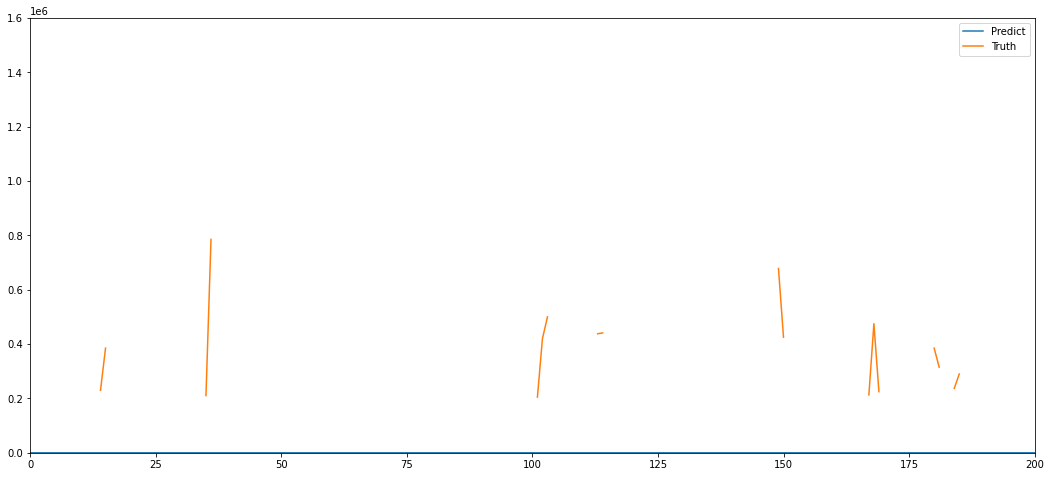

In [31]:
hos_pre = pd.DataFrame()
hos_pre['Predict'] = pred
hos_pre['Truth'] = y_test
hos_pre.plot(figsize = (18,8))
plt.ylim(0,1600000)
plt.xlim(0,200)

In [32]:
# Get the model with the highest mean validation accuracy
second_model = df_results.iloc[1]

# Fit the model
model = models[second_model[0]]['model']
model.fit(X_train,y_train)

# Predict the labels with the data set
pred = model.predict(X_test)

RMSE = mean_squared_error(np.log1p(y_test),pred)**0.5
RMSE = RMSE

# Display the results
printmd(f'### Best Model: {second_model[0]} with a RMSE of {RMSE} on the test set')
printmd(f'### Trained in: {second_model[2]} sec')

### Best Model: GradientBoostingRegressor with a RMSE of 0.14436324250995328 on the test set

### Trained in: 9.2324 sec

In [33]:
# Get the model with the highest mean validation accuracy
third_model = df_results.iloc[2]

# Fit the model
model = models[third_model[0]]['model']
model.fit(X_train,y_train)

# Predict the labels with the data set
pred = model.predict(X_test)

RMSE = mean_squared_error(np.log1p(y_test),pred)**0.5
RMSE = RMSE

# Display the results
printmd(f'### Best Model: {third_model[0]} with a RMSE of {RMSE} on the test set')
printmd(f'### Trained in: {third_model[2]} sec')

### Best Model: Lasso with a RMSE of 0.22216422997249555 on the test set

### Trained in: 0.1872 sec

In [34]:
# Get the model with the highest mean validation accuracy
forth_model = df_results.iloc[3]

# Fit the model
model = models[forth_model[0]]['model']
model.fit(X_train,y_train)

# Predict the labels with the data set
pred = model.predict(X_test)

RMSE = mean_squared_error(np.log1p(y_test),pred)**0.5
RMSE = RMSE

# Display the results
printmd(f'### Best Model: {forth_model[0]} with a RMSE of {RMSE} on the test set')
printmd(f'### Trained in: {forth_model[2]} sec')

### Best Model: LinearRegression with a RMSE of 0.22216472095324707 on the test set

### Trained in: 0.0162 sec

In [35]:
print(best_model)
print(df_results)

model                  LightGBM
RMSE                   0.148559
Training time (sec)      4.3689
Name: 0, dtype: object
                       model      RMSE  Training time (sec)
0                   LightGBM  0.148559               4.3689
1  GradientBoostingRegressor  0.152393               9.2324
2                      Lasso  0.229740               0.1872
3           LinearRegression  0.229741               0.0162
4                   Stacking       NaN               0.0049


# 4. Visualization of the result<a class="anchor" id="4"></a>

In [36]:
# Concatenate the ratings of the test set
# with the predictions of those ratings
pred_s = pd.Series(pred)
y_test_s = y_test.reset_index(drop=True)

df_result = pd.concat([y_test_s,pred_s], axis = 1)
df_result.columns = ['Real Rating', 'Predicted Rating']
df_result.head(10)

,Real Rating,Predicted Rating
0,223000.0,12.425163
1,165050.0,12.124314
2,518000.0,13.062515
3,533500.0,13.152460
4,400000.0,12.872577
5,435000.0,12.973657
6,390000.0,12.728601
7,259000.0,12.512448
8,542000.0,13.225021
9,252000.0,12.299564


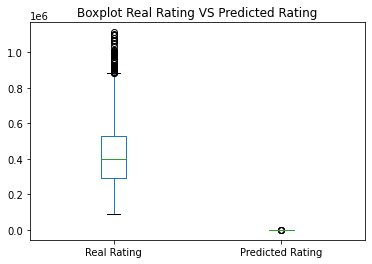

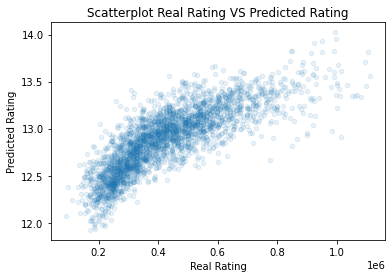

In [37]:
df_result.plot.box()
plt.title('Boxplot Real Rating VS Predicted Rating', fontsize = 12)
plt.show()

df_result.plot.scatter(x='Real Rating', y='Predicted Rating', alpha = 0.1)
plt.title('Scatterplot Real Rating VS Predicted Rating', fontsize = 12)
plt.show()